# Differential Flatness of a Car


In [1]:
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=22)
rc('figure', figsize=(8,6))
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
from IPython.display import display
from sympy import init_printing
init_printing(use_latex='mathjax')
import sympy as sp


from sympy.physics.vector import dynamicsymbols
t = sp.symbols('t')
display(sp.Integral(sp.sqrt(1/t), t))


x = dynamicsymbols('x_d')
xd = sp.diff(x, t)
y = dynamicsymbols('y_d')
yd = sp.diff(y, t)

v = sp.sqrt(xd**2 + yd**2)
vd = sp.diff(v, t)
vdd = sp.diff(vd, t)
display(vd)
display(vdd)

⌠           
⎮     ___   
⎮    ╱ 1    
⎮   ╱  ─  dt
⎮ ╲╱   t    
⌡           

             2                        2        
d           d            d           d         
──(x_d(t))⋅───(x_d(t)) + ──(y_d(t))⋅───(y_d(t))
dt           2           dt           2        
           dt                       dt         
───────────────────────────────────────────────
           _______________________________     
          ╱             2               2      
         ╱  ⎛d         ⎞    ⎛d         ⎞       
        ╱   ⎜──(x_d(t))⎟  + ⎜──(y_d(t))⎟       
      ╲╱    ⎝dt        ⎠    ⎝dt        ⎠       

                                                                              
⎛               2                        2        ⎞ ⎛             2           
⎜  d           d            d           d         ⎟ ⎜d           d            
⎜- ──(x_d(t))⋅───(x_d(t)) - ──(y_d(t))⋅───(y_d(t))⎟⋅⎜──(x_d(t))⋅───(x_d(t)) + 
⎜  dt           2           dt           2        ⎟ ⎜dt           2           
⎝             dt                       dt         ⎠ ⎝           dt            
──────────────────────────────────────────────────────────────────────────────
                                                                 3/2          
                                  ⎛            2               2⎞             
                                  ⎜⎛d         ⎞    ⎛d         ⎞ ⎟             
                                  ⎜⎜──(x_d(t))⎟  + ⎜──(y_d(t))⎟ ⎟             
                                  ⎝⎝dt        ⎠    ⎝dt        ⎠ ⎠             

                                                   

In [3]:
xd, xdd, xddd, yd, ydd, yddd = sp.symbols('xd, xdd, xddd, yd, ydd, yddd')
vdd = 2*xdd**2 + 2*xd*xddd + 2*ydd**2 + 2*yd*yddd
vddsq = sp.expand(vdd**2)
print(vddsq)

4*xd**2*xddd**2 + 8*xd*xdd**2*xddd + 8*xd*xddd*yd*yddd + 8*xd*xddd*ydd**2 + 4*xdd**4 + 8*xdd**2*yd*yddd + 8*xdd**2*ydd**2 + 4*yd**2*yddd**2 + 8*yd*ydd**2*yddd + 4*ydd**4


In [4]:
# car parameters
ell = 2.5

# time
ts = 0.
te = 20.

npts = 100 # number of points to discretize at

# time
tvec = np.arange(ts, te, 1./npts)

# parameters 0:6 are p_xi 6:12 are p_yi
nparam = 6
ndim = 2
P0 = np.zeros((nparam*ndim))


# path derivatives
def P_0d(P, t, p0):
    PP = P[p0:nparam+p0]
    TT = np.stack([ t**0,
                    t**1,
                    t**2,
                    t**3,
                    t**4,
                    t**5])
    func = PP@TT
    return func

def P_1d(P, t, p0):
    PP = P[p0:nparam+p0]
    TT = np.stack([ 0*t**0,
                    1*t**0,
                    2*t**1,
                    3*t**2,
                    4*t**3,
                    5*t**4])
    func = PP@TT
    return func

def P_2d(P, t, p0):
    PP = P[p0:nparam+p0]
    TT = np.stack([ 0*t**0,
                    0*t**0,
                    2*t**0,
                    6*t**1,
                    12*t**2,
                    20*t**3])
    func = PP@TT
    return func

def P_3d(P, t, p0):
    PP = P[p0:nparam+p0]
    TT = np.stack([ 0*t**0,
                    0*t**0,
                    0*t**0,
                    6*t**0,
                    24*t**1,
                    60*t**2])
    func = PP@TT
    return func


# objective function
def Jmin(P):
    
#    xd   = P_1d(P, tvec, 0)
#    xdd  = P_2d(P, tvec, 0)
    xddd = P_3d(P, tvec, 0)
    
#    yd   = P_1d(P, tvec, nparam)
#    ydd  = P_2d(P, tvec, nparam)
    yddd = P_3d(P, tvec, nparam)
    
    vdd = xddd**2 + yddd**2
    
    J = sum(vdd**2)
    return J
    
    



In [20]:
# constraints
def maxSteer(P):
    xd   = P_1d(P, tvec, 0)
    xdd  = P_2d(P, tvec, 0) 
    yd   = P_1d(P, tvec, nparam)
    ydd  = P_2d(P, tvec, nparam)
    
    v = np.sqrt(xd**2 + yd**2)
    gmax = np.min(v*np.tan(np.pi/4)/ell - np.abs(ydd*xd + yd*xdd))
    #import pdb; pdb.set_trace()
    return gmax
    
constraintList = [
# x(0) = (0, 0)
    {'type': 'eq', 'fun': lambda P: P_0d(P, np.array([ts]), 0)},
    {'type': 'eq', 'fun': lambda P: P_0d(P, np.array([ts]), nparam)},
# x(5) = (5, 3)
    #{'type': 'eq', 'fun': lambda P: P_0d(P, np.array([5]), 0) - 5},
    #{'type': 'eq', 'fun': lambda P: P_0d(P, np.array([5]), nparam) - 2},
# x(te) = (10, 5)
    {'type': 'eq', 'fun': lambda P: P_0d(P, np.array([te]), 0) - 1},
    {'type': 'eq', 'fun': lambda P: P_0d(P, np.array([te]), nparam) - 0},
# xd(0) = (0, 1)
    {'type': 'eq', 'fun': lambda P: P_1d(P, np.array([ts]), 0) - 0},
    {'type': 'eq', 'fun': lambda P: P_1d(P, np.array([ts]), nparam) - 2},
# xd(te) = (0, 0)
    {'type': 'eq', 'fun': lambda P: P_1d(P, np.array([te]), 0) },
    {'type': 'eq', 'fun': lambda P: P_1d(P, np.array([te]), nparam) - 1},
# Max vel < 10 m/s
    {'type': 'ineq', 'fun': lambda P: 10**2 - np.amax(P_1d(P, tvec, 0)**2 + P_1d(P, tvec, nparam)**2)},
# Max accel < 2 m/ss
    {'type': 'ineq', 'fun': lambda P: 2**2 - np.amax(P_2d(P, tvec, 0)**2 + P_2d(P, tvec, nparam)**2)},
# Max steer < 45 deg
    {'type': 'ineq', 'fun': maxSteer}
]

In [21]:
def cb(state):
    pass
    #print(state)
    
res = minimize(Jmin, P0, method='SLSQP', constraints=constraintList, callback=cb)
print(res)

     fun: 0.007131890459005952
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.30965681e-01,
       -5.43301394e+00, -1.66867933e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.78305340e+00,  1.51381985e+02,  4.54327555e+03])
 message: 'Optimization terminated successfully.'
    nfev: 286
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([ 0.00000000e+00, -1.89848066e-22,  7.75564718e-03, -3.43695016e-04,
        7.45214774e-06, -1.70325745e-07,  0.00000000e+00,  2.00000000e+00,
       -2.32123404e-01,  3.92678132e-03,  2.23247396e-04, -4.46389765e-06])


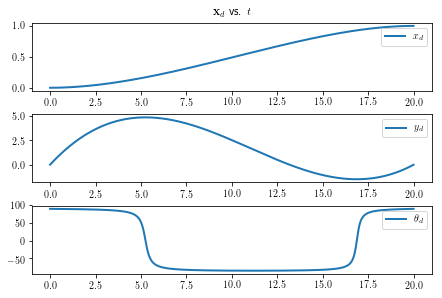

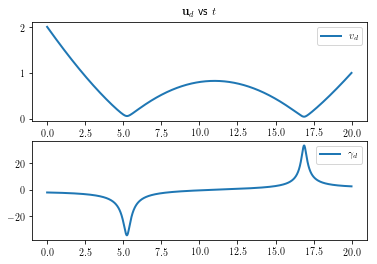

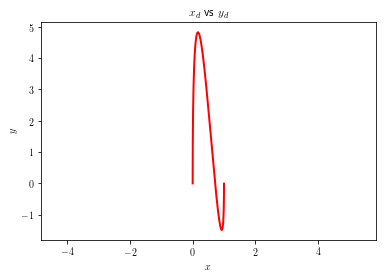

In [22]:
# use the result!
Popt = res.x

xtraj = P_0d(Popt, tvec, 0)
ytraj = P_0d(Popt, tvec, nparam)

xtraj_dot = P_1d(Popt, tvec, 0)
ytraj_dot = P_1d(Popt, tvec, nparam)

xtraj_ddot = P_2d(Popt, tvec, 0)
ytraj_ddot = P_2d(Popt, tvec, nparam)

thetatraj = np.arctan2(ytraj_dot, xtraj_dot)

vtraj = np.sqrt(xtraj_dot**2 + ytraj_dot**2)
gamtraj = np.arctan2(ell * (ytraj_ddot*xtraj_dot - ytraj_dot*xtraj_ddot), vtraj)

fig, ax = plt.subplots(3, 1)
ax[0].set_title(r"$\mathbf{x}_d$ vs. $t$")
ax[0].plot(tvec,xtraj, label=r"$x_d$", linewidth=2)
ax[0].legend()
ax[1].plot(tvec,ytraj, label =r"$y_d$", linewidth=2)
ax[1].legend()
ax[2].plot(tvec,np.rad2deg(thetatraj), label =r"$\theta_d$", linewidth=2)
ax[2].legend()
fig.tight_layout(pad=.2)
#fig.savefig('car_df_states.png', dpi=600)

fig, ax = plt.subplots(2, 1)
ax[0].set_title(r"$\mathbf{u}_d$ vs $t$")
ax[0].plot(tvec, vtraj, label=r"$v_d$", linewidth=2)
ax[0].legend()
ax[1].plot(tvec, np.rad2deg(gamtraj), label=r"$\gamma_d$", linewidth=2)
ax[1].legend()
#fig.savefig('car_df_inputs.png', dpi=600)

fig, ax = plt.subplots(1, 1)
ax.set_title(r"$x_d$ vs $y_d$")
ax.plot(xtraj, ytraj, linewidth=2, color='r')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.axis('equal')
#fig.savefig('car_df_xy.png', dpi=600)


plt.show()



---
## Using the Python Control Library
I recently became aware that the [python control library](python-control.readthedocs.io) has a set of classes for generating trajectories for differentially flat systems.

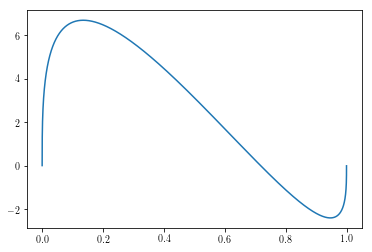

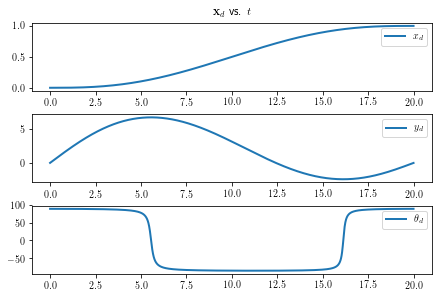

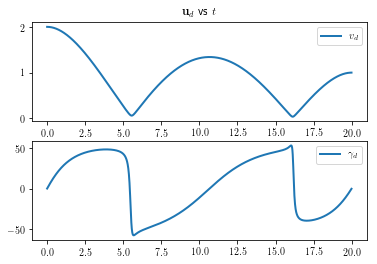

In [19]:
import control.flatsys as fs

# given states and inputs, compute the flat flag
def car_flat_forward(x, u):
    
    # flat flag 
    # zflag = [[x_d, y_d], [x_dot, y_dot], [x_ddot, y_ddot]]
    zflag = [np.zeros(3), np.zeros(3)]
    
    # z
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]
    
    # zdot
    zflag[0][1] = u[0] * np.cos(x[2])
    zflag[1][1] = u[0] * np.sin(x[2])
    
    thdot = (u[0]/ell) * np.tan(u[1])
    
    # zddot
    zflag[0][2] = -u[0] * np.sin(x[2]) * thdot
    zflag[1][2] = u[0] * np.cos(x[2]) * thdot
    
    return zflag

def car_flat_reverse(zflag):
    x = np.zeros(3)
    u = np.zeros(2)
    
    x[0] = zflag[0][0] # x_d
    x[1] = zflag[1][0] # y_d
    x[2] = np.arctan2(zflag[1][1], zflag[0][1]) # theta = atan(ydot/xdot)
    
    u[0] = np.sqrt(zflag[0][1]**2 + zflag[1][1]**2) # sqrt(xdot^2 + ydot^2)
    u[1] = np.arctan2(ell * (zflag[1][2]*zflag[0][1] - zflag[1][1]*zflag[1][2]), u[0])

    return x, u

car_flat = fs.FlatSystem(car_flat_forward, car_flat_reverse, inputs=2, states=3)

x0 = [0., 0., np.pi/2]
u0 = [2., 0.]
xf = [1., 0., np.pi/2]
uf = [1., 0.]
Tf = 20

poly = fs.PolyFamily(6)

traj = fs.point_to_point(car_flat, x0, u0, xf, uf, Tf, basis=poly)

xvec, uvec = traj.eval(tvec)

fig, ax = plt.subplots(1,1)
ax.plot(xvec[0], xvec[1])

fig, ax = plt.subplots(3, 1)
ax[0].set_title(r"$\mathbf{x}_d$ vs. $t$")
ax[0].plot(tvec,xvec[0], label=r"$x_d$", linewidth=2)
ax[0].legend()
ax[1].plot(tvec,xvec[1], label =r"$y_d$", linewidth=2)
ax[1].legend()
ax[2].plot(tvec,np.rad2deg(xvec[2]), label =r"$\theta_d$", linewidth=2)
ax[2].legend()
fig.tight_layout(pad=.2)

fig, ax = plt.subplots(2, 1)
ax[0].set_title(r"$\mathbf{u}_d$ vs $t$")
ax[0].plot(tvec, uvec[0], label=r"$v_d$", linewidth=2)
ax[0].legend()
ax[1].plot(tvec, np.rad2deg(uvec[1]), label=r"$\gamma_d$", linewidth=2)
ax[1].legend()
